In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import pandas as pd
import scipy.stats
from matplotlib.gridspec import GridSpec
import sys
sys.path.insert(1, '../')
import my_utils as myf
import importlib
importlib.reload(myf)
plt.rcParams.update({'font.size': 12})

In [2]:
runmap = pd.read_csv('../e2.1runmap.csv',sep=',')
allens = runmap['names'].values

In [3]:
datadir = myf.processed_dir+'timeseries/sia/'
myfiles = [f for f in sorted(os.listdir(datadir)) if '.nc' in f]
listds = []
for f in myfiles:
    ds = xr.open_dataset(datadir+f)
    if 'time' in ds:
        ds = ds.groupby('time.year').mean(dim='time')
    listds.append(ds)
sids = xr.concat(listds,dim='names')

In [4]:
datadir = myf.processed_dir+'timeseries/tos/'
myfiles = [f for f in sorted(os.listdir(datadir)) if '.nc' in f]
listds = []
for f in myfiles:
    ds = xr.open_dataset(datadir+f)
    if 'time' in ds:
        ds = ds.groupby('time.year').mean(dim='time')
    listds.append(ds[['tos']])
tosds = xr.concat(listds,dim='names')

In [5]:
ds = xr.merge([tosds,sids])

In [6]:
ens_ctrl = [f for f in allens if 'f2' in f or 'f1' in f]
ens_mw = [f for f in allens if 'f4' in f]
ens_wind = [f for f in allens if 'f5' in f]
ens_windmw = [f for f in allens if 'f6' in f]

for n, myens in enumerate([ens_ctrl,ens_mw, ens_wind, ens_windmw]):
    ds_add = ds.sel(names=myens).mean(dim='names')
    ds_add['names'] = ['CTRLmean','MWmean','WINDmean','WIND&MWmean'][n]
    ds_add = ds_add.set_coords('names')
    ds = xr.concat([ds,ds_add],dim='names')

In [7]:
df = myf.plot_prop_from_names(ds.names.values)

In [8]:
def check_consistency(ds, refname, var, y1, y2):
    ds = ds.sel(year=slice(y1,y2))
    anom = ds - ds.mean(dim='year')
    slope, intercept, r_value, p_value, std_err = myf.linregress(ds.year,ds.load(),dim='year')
    slope = 10.*slope
    ny = y2 - y1
    
    nmod = len(ds.sel(names=[f for f in ds.names.values if ('f1' in f or 'f2' in f)]).names.values)
    sd_model = slope[var].sel(names=[f for f in ds.names.values if ('f1' in f or 'f2' in f)]).std(dim='names').values
    mean_model = slope[var].sel(names=[f for f in ds.names.values if ('f1' in f or 'f2' in f)]).mean(dim='names').values
    obs = slope[var].sel(names=refname).values
    se_obs = std_err[var].sel(names=refname).values
    
    d = abs(mean_model - obs)/np.sqrt(sd_model**2. + se_obs**2)    
    dof = nmod-1 #+(ne-2)
    p = scipy.stats.t.sf(abs(d), df=dof)*2
    
    print('P-value, for {:.2f} DOF, two-tailed, = {:.4f}, is CTRL ensemble consistent with OBS? {}'.format(dof,p,p>0.05))
    
    return
    

In [9]:
for name in ds.names.values:
    if 'OBS-CDR' in name:
        print(name+' 1990-2021')
        check_consistency(ds, name, 'sia_sh', 1990, 2021)

OBS-CDRv4-bt 1990-2021
P-value, for 19.00 DOF, two-tailed, = 0.5659, is CTRL ensemble consistent with OBS? True
OBS-CDRv4-cdr 1990-2021
P-value, for 19.00 DOF, two-tailed, = 0.5433, is CTRL ensemble consistent with OBS? True
OBS-CDRv4-nt 1990-2021
P-value, for 19.00 DOF, two-tailed, = 0.4023, is CTRL ensemble consistent with OBS? True


In [10]:
for name in ds.names.values:
    if 'OBS-CDR' in name:
        print(name+' 1979-2021')
        check_consistency(ds, name, 'sia_sh', 1979, 2021)

OBS-CDRv4-bt 1979-2021
P-value, for 19.00 DOF, two-tailed, = 0.0785, is CTRL ensemble consistent with OBS? True
OBS-CDRv4-cdr 1979-2021
P-value, for 19.00 DOF, two-tailed, = 0.0510, is CTRL ensemble consistent with OBS? True
OBS-CDRv4-nt 1979-2021
P-value, for 19.00 DOF, two-tailed, = 0.0640, is CTRL ensemble consistent with OBS? True


In [11]:
print('NOAA-ERSST 1990-2021')
check_consistency(ds.sel(region='50-65S'), 'OBS-ERSSTv5', 'tos',1990, 2021)

NOAA-ERSST 1990-2021
P-value, for 19.00 DOF, two-tailed, = 0.0527, is CTRL ensemble consistent with OBS? True


In [12]:
print('NOAA-ERSST 1979-2021')
check_consistency(ds.sel(region='50-65S'), 'OBS-ERSSTv5', 'tos',1979, 2021)

NOAA-ERSST 1979-2021
P-value, for 19.00 DOF, two-tailed, = 0.0095, is CTRL ensemble consistent with OBS? False


In [13]:
# reorder how I want
ds = ds.sel(names=['r210i1p1f1', 'r201i1p1f1', 'r202i1p1f1', 'r203i1p1f1', 'r204i1p1f1', 'r205i1p1f1', 'r206i1p1f1',
                   'r207i1p1f1', 'r208i1p1f1', 'r209i1p1f1', 'r10i1p1f2', 'r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 
                   'r4i1p1f2', 'r5i1p1f2', 'r6i1p1f2', 'r7i1p1f2', 'r8i1p1f2', 'r9i1p1f2', 'CTRLmean',
                   'r210i1p1f4', 'r201i1p1f4', 'r202i1p1f4', 'r203i1p1f4', 'r204i1p1f4', 'r205i1p1f4', 
                   'r206i1p1f4', 'r207i1p1f4', 'r208i1p1f4', 'r209i1p1f4', 'MWmean',
                   'r201i1p1f5', 'r1i1p1f5', 'r202i1p1f5',  'r201i1p1f6', 'r202i1p1f6', 'WINDmean',  'WIND&MWmean', 
                   'OBS-CDRv4-cdr', 'OBS-CDRv4-bt', 'OBS-CDRv4-nt','OBS-ERSSTv5',])

In [14]:
def make_plot(ds):
    
    fig = plt.figure(figsize=(10,10))
    plt.rcParams.update({'font.size': 12})
    for v, var in enumerate(['tos','sia_sh']):
        y1, y2 = 1986, 2021
        anom = ds - ds.sel(year=slice(1990,2021)).mean(dim='year')
        anom = anom.sel(year=slice(y1,y2))
        slope, intercept, r_value, p_value, std_err = myf.linregress(ds.year,ds.load(),dim='year')
        slope = 10.*slope

        gs = GridSpec(2, 2, width_ratios=[4, 1])
        ax = fig.add_subplot(gs[v*2])
        for name in ds.names.values:
            ls = '-'
            if 'MW' in name or 'f6' in name:
                ls = '--'
            if 'WINDmean' not in name and 'f4' not in name and 'WIND&MWmean' not in name:
                anom.sel(names=name)[var].plot(ax=ax, **df[name].to_dict(),linestyle=ls)
        
        ax.set_xlim([y1,y2])
        ax.set_title('')
        ax.set_title(['(a)','(c)'][v],loc='left',fontsize=12)
        ax.set_ylabel(['SST anomaly [K]','Sea ice area anomaly [10$^6$ km$^2$]'][v])
        ax.set_xlabel('')
        if var=='tos':
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys(),ncol=2)
 
    for v, var in enumerate(['tos','sia_sh']):
        y1, y2 = 1990, 2021
        ds = ds.sel(year=slice(y1,y2))
        anom = ds - ds.mean(dim='year')
        slope, intercept, r_value, p_value, std_err = myf.linregress(ds.year,ds.load(),dim='year')
        slope = 10.*slope
        ax = fig.add_subplot(gs[v*2 + 1])
        mylabels = []
        for name in ds.names.values:
            if 'OBS' in name:
                ax.errorbar(0,slope[var].sel(names=name), fmt='.',yerr=10.*std_err[var].sel(names=name),c='k',
                                    capsize=7, elinewidth=2) 
                ax.scatter(0, slope[var].sel(names=name),**df[name],s=150)
            if 'f1' in name or 'f2' in name:  
                ax.scatter(1, slope[var].sel(names=name),**df[name],s=150)
            if 'f5' in name:
                ax.scatter(2, slope[var].sel(names=name),**df[name],s=150)
            if 'f6' in name: 
                ax.scatter(3, slope[var].sel(names=name),**df[name],s=150)
            elif 'f4' in name:
                ax.scatter(4, slope[var].sel(names=name),**df[name],s=150)

        ax.scatter(1, slope[var].sel(names='CTRLmean'),c=df['CTRLmean']['c'], s=350, marker='x')
        ax.scatter(4, slope[var].sel(names='MWmean'),c=df['MWmean']['c'], s=350, marker='x')

        ax.set_title(['(b)','(d)'][v]+' Trend '+str(y1)+'-'+str(y2),fontsize=12)
        ax.set_ylabel(['SST trend [K/decade]','Sea ice area trend [10$^6$ km$^2$/decade]'][v])
        ax.set_xticks(np.arange(5))
        ax.set_xlim([-1,5])
        ax.set_xticklabels(['OBS','CTRL','WIND','WIND&MW','MW'],rotation='vertical')
        ax.axhline(y=0,c='k',linewidth=.25)
    plt.tight_layout()
    fig.savefig('../figs/fig3.pdf',dpi=300,bbox_inches='tight',facecolor='white')
    plt.show()
    plt.close()
    
    return

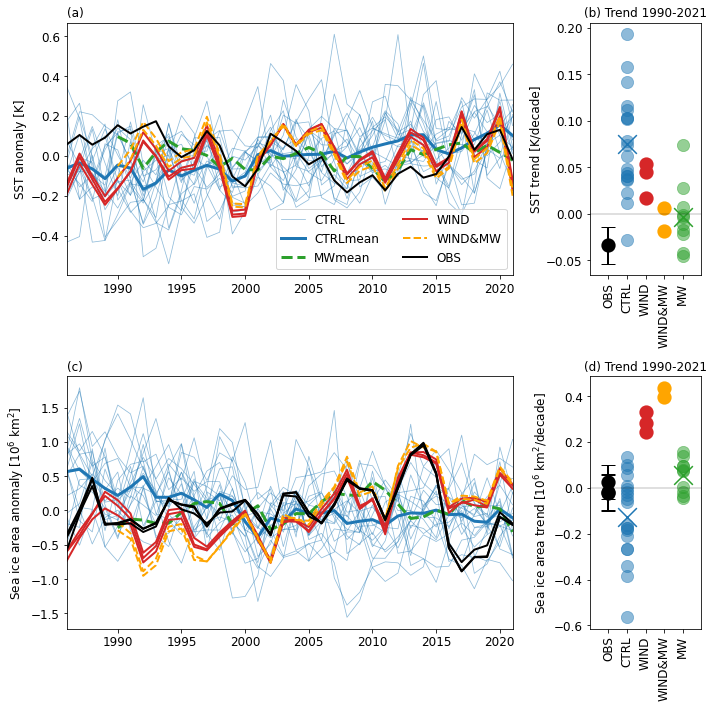

In [15]:
make_plot(ds.sel(region='50-65S'))

In [16]:
def make_plot2(ds,y1, y2):
    plt.rcParams.update({'font.size': 12})
    ds = ds.sel(year=slice(y1,y2))
    anom = ds - ds.mean(dim='year')
    slope, intercept, r_value, p_value, std_err = myf.linregress(ds.year,ds.load(),dim='year')
    slope = 10.*slope
    
    fig = plt.figure(figsize=(8,4))
    varlabels = ['Global SST','SO SST','SIA']
    units = ['K/decade','K/decade','million km$^2$/decade']
    se = [std_err.tos.sel(region='Global'),std_err.tos.sel(region='50-65S'),std_err.sia_sh]
    for p, mydata in enumerate([slope.tos.sel(region='Global'),slope.tos.sel(region='50-65S'),slope.sia_sh]):
        
        ax = plt.subplot(1,3,p+1)
        mylabels = []
        for name in ds.names.values:
            if 'OBS' in name:
                ax.errorbar(0,mydata.sel(names=name), fmt='.',yerr=10.*se[p].sel(names=name),c='k',
                                    capsize=7, elinewidth=2) 
                ax.scatter(0, mydata.sel(names=name),**df[name],s=150)
            if 'f1' in name or 'f2' in name: 
                ax.scatter(1, mydata.sel(names=name),**df[name],s=150)

        ax.scatter(1, mydata.sel(names='CTRLmean'),c=df['CTRLmean']['c'], s=350, marker='x')

        ax.set_title(myf.alphabet[p]+' '+varlabels[p],fontsize=12, loc='left')
        ax.set_ylabel('Trend ['+units[p]+']')
        ax.set_xticks(np.arange(2))
        ax.set_xlim([-1,2])
        ax.set_xticklabels(['OBS','CTRL'],rotation='vertical')
        if p>0:
            ax.axhline(y=0,c='k',linewidth=.25)
    plt.tight_layout()
    fig.savefig('../figs/fig1.pdf',dpi=300,bbox_inches='tight')
    plt.show()
    plt.close()
    
    return

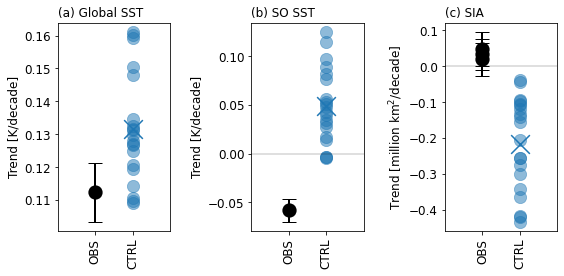

In [17]:
make_plot2(ds,1979,2021)

In [18]:
def make_plot_trend_vs_trend(ds, y1, y2):
    region = ds.region.values
    ds = ds.sel(year=slice(y1,y2))
    anom = ds - ds.mean(dim='year')
    slope, intercept, r_value, p_value, std_err = myf.linregress(ds.year,ds.load(),dim='year')
    slope = 10.*slope

    fig, ax = plt.subplots(1,figsize=(7,5))
    
    sialist = []
    toslist = []
    for name in ds.names.values:
        if 'f1' in name or 'f2' in name: 
            ax.scatter(slope.tos.sel(names=name), slope.sia_sh.sel(names=name),
                       c=df[name]['c'],label = df[name]['label'])
            sialist.append(slope.sia_sh.sel(names=name))
            toslist.append(slope.tos.sel(names=name))

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.asarray(toslist),np.asarray(sialist))
    if abs(r_value)>0.5:
        ax.plot(np.asarray(toslist), slope*np.asarray(toslist) + intercept, alpha=.5, c='tab:pink', label='R$^2$={:.2f}'.format(r_value**2))
    
    ax.set_title('Trend '+str(y1)+'-'+str(y2)+', SST '+str(ds.region.values),fontsize=12)
    ax.set_xlabel('SST trend (K/decade)')
    ax.set_ylabel('SIA trend (10$^6$ km$^2$/decade)')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc=(1.1,0))
    ax.axhline(y=0,c='k',linewidth=.25)
    ax.axvline(x=0,c='k',linewidth=.25)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return 

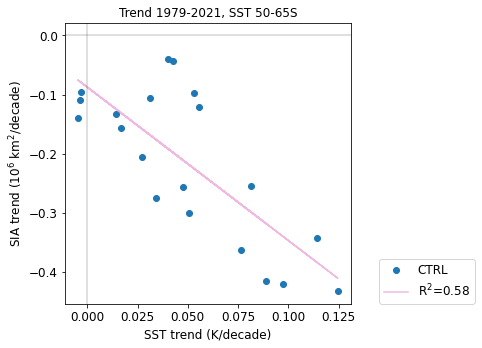

In [19]:
make_plot_trend_vs_trend(ds.sel(region='50-65S'),1979,2021)